In [20]:
#import relevant libraries 
import pandas as pd
import plotly.express as px
import panel as pn
import hvplot.pandas
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path
import alpaca_trade_api as tradeapi
from dotenv import load_dotenv
import os
from datetime import datetime, timedelta,date
from pandas import DataFrame



In [21]:
## Get Market Data for S&P500 
#engage API keys by activating .env file for Alpaca Api
load_dotenv()
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
alpaca_base_url=os.getenv("APCA_API_BASE_URL")
api = tradeapi.REST(alpaca_api_key, alpaca_secret_key,alpaca_base_url, api_version='v2')

#function to read the api data for stock ticker
#returns dataframe of closing price and daily returns for a given ticker symbol
def get_ticker_data(api,ticker):
    #load in historical data for provided ticker
    stock_data_df = api.alpha_vantage.historic_quotes(ticker, adjusted=True, output_format='pandas')

    #Clean Data
    

    #Sort earliest to latest. so that .pct_change() function works right.
    stock_data_df.sort_index(inplace=True, ascending=True)

    # Drop nulls
    stock_data_df.dropna(inplace=True)

    # drop duplicates
    stock_data_df.drop_duplicates(inplace=True)

    #count nulls 
    stock_data_df.isnull().sum()

    #create a dataframe column for the daily returns (pct_change) values and concat 
    returns_df = stock_data_df['5. adjusted close'].pct_change()
    stock_data_df = pd.concat([stock_data_df, returns_df], axis="columns", join="inner")

    #Change column names to avoid confusion
    columns = ['Open','High','Low','Close','Adjusted Close','Volume','Dividend Amount','Split Coefficient','Daily Returns']
    stock_data_df.columns = columns

    # Drop nulls
    stock_data_df.dropna(inplace=True)

    #drop duplicates
    stock_data_df.drop_duplicates(inplace=True) 
    return stock_data_df

In [22]:
stock_data_df=get_ticker_data(api,'SPY')

In [24]:
#EMA Simulator to assess the asset and choose ideal, optimized short and long windows
class EMASimulator:
    def __init__(self, stock_data_df, period, long_window, short_window, figsize=None):
        self.stock_data_df = stock_data_df
        #self.from_date = from_date
        self.period = period
        self.long_window = long_window
        self.short_window = short_window
        self.figsize = figsize
    
    def _build_dataframe(self):
        self.stock_data_df.sort_index(ascending=True, inplace=True)
        
                
    def _ema(self):
        self.stock_data_df['EWM Short'] = self.stock_data_df['Close'].ewm(span=self.short_window).mean()
        self.stock_data_df['EWM Long']= self.stock_data_df['Close'].ewm(span=self.long_window).mean()
        
    def _calculate_ema_signals(self):
        self.stock_data_df['EMA Signal'] = None

        mode = 'Open'
        for index in range(len(self.stock_data_df)):
            if index == 0:
                continue

            row = self.stock_data_df.iloc[index]
            prev_row = self.stock_data_df.iloc[index - 1]

            # open?
            if mode == 'Open' and row['EWM Short'] > row['EWM Long']  and prev_row['EWM Short'] < prev_row['EWM Long']:
                self.stock_data_df.iloc[index, self.stock_data_df.columns.get_loc('EMA Signal')] = 1
                mode = 'Close'

            # close?
            if mode == 'Close' and row['EWM Long'] > row['EWM Short'] and prev_row['EWM Long'] < prev_row['EWM Short']:
                self.stock_data_df.iloc[index, self.stock_data_df.columns.get_loc('EMA Signal')] = -1
                mode = 'Open'        
        
    def _returns(self):
        self.stock_data_df['EMA Signal'].fillna(method='ffill', inplace=True)
        self.stock_data_df['EMA Daily Return'] = self.stock_data_df['Close'].pct_change()
        self.stock_data_df['EMA Strategy Return'] = self.stock_data_df['EMA Daily Return'] * self.stock_data_df['EMA Signal']

    def _plot_returns(self):
        self.stock_data_df['EMA Strategy Return'].cumsum().plot(figsize=self.figsize)

    def simulate(self):
        self._build_dataframe()
        self._ema()
        self._calculate_ema_signals()
        self._returns()
        self._plot_returns()

        return (
            self.period, 
            self.long_window, 
            self.short_window, 
            self.stock_data_df['EMA Strategy Return'].sum(),
            self.stock_data_df['EMA Signal']
        )

('24H', 50, 100, -1.1280297371049814)

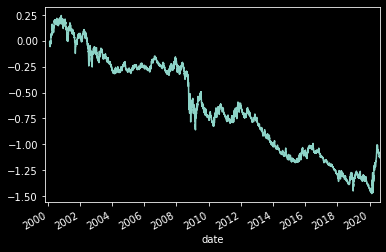

In [5]:
simulator = EMASimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period="24H", 
    long_window=50, 
    short_window=100
)
simulator.simulate()

In [28]:
#EMA Optimal Calculation
def EMA_Optimal(stock_data_df):
    long_windows = np.linspace(10, 100, 5, dtype=int)
    short_windows = np.linspace(10, 100, 5, dtype=int)
    periods = np.array([12, 48])

    result_df = pd.DataFrame({
        'period': [], 
        'long_window': [],
        'short_window': [],
        'result': []
    })
    for long_window in long_windows:
        for short_window in short_windows:
            for period in periods:
                simulator = EMASimulator(
                    stock_data_df, 
                    #from_date 
                    period="{}H".format(period), 
                    long_window=long_window, 
                    short_window=short_window,
                    figsize=(14, 7)
                )
                period, long_window, short_window, result, signal = simulator.simulate()
                result_df = result_df.append({
                    'period': period, 
                    'long_window': long_window, 
                    'short_window': short_window, 
                    'result': result,
                    'signal': signal
                }, ignore_index=True)
    ema_result=result_df.sort_values(by=['result'], ascending=False)[:5]
    return ema_result

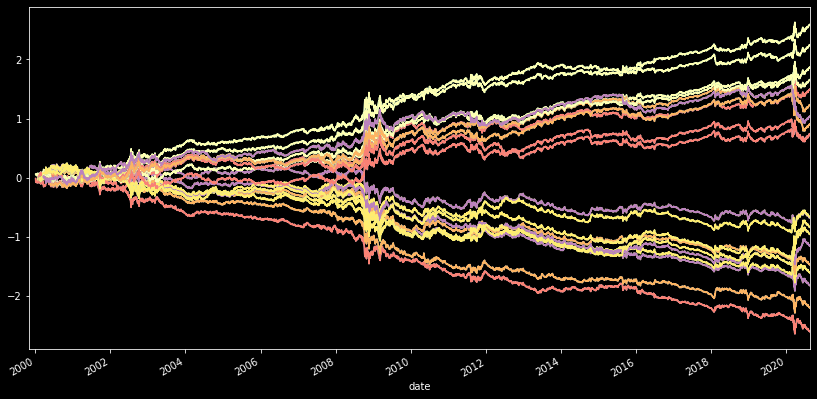

In [29]:
ema_result=EMA_Optimal(stock_data_df)

In [30]:
opt_ema_df=ema_result.head()
opt_ema_df

period  long_window  short_window    result  \
11    48H         32.0          10.0  2.592552   
10    12H         32.0          10.0  2.592552   
21    48H         55.0          10.0  2.249723   
20    12H         55.0          10.0  2.249723   
30    12H         77.0          10.0  1.871804   

                                               signal  
11  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
10  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
21  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
20  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
30  date
1999-11-02    NaN
1999-11-03    NaN
1999-...

In [32]:
period=opt_ema_df['period'].iloc[0]
long_window=opt_ema_df['long_window'].iloc[0]
short_window=opt_ema_df['short_window'].iloc[0]

('48H', 32.0, 10.0, 2.592552469111952, date
 1999-11-02    NaN
 1999-11-03    NaN
 1999-11-04    NaN
 1999-11-05    NaN
 1999-11-08    NaN
              ... 
 2020-08-12    1.0
 2020-08-13    1.0
 2020-08-14    1.0
 2020-08-17    1.0
 2020-08-18    1.0
 Name: EMA Signal, Length: 5232, dtype: float64)

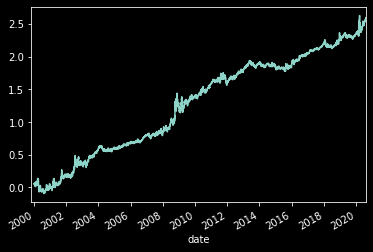

In [33]:
simulator = EMASimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    long_window=long_window, 
    short_window=short_window
)
simulator.simulate()

In [34]:
#Bollinger Bands Simulator to assess the asset and choose ideal, optimized bollinger window, no of standard deviations, and period.
class BollingerBandsSimulator:

    def __init__(self, stock_data_df, period, bollinger_window, no_of_std, figsize=None):
        self.stock_data_df = stock_data_df
        #self.from_date = from_date
        self.period = period
        self.bollinger_window = bollinger_window
        self.no_of_std = no_of_std
        self.figsize = figsize
    
    def _build_dataframe(self):
        self.stock_data_df.sort_index(ascending=True, inplace=True)
        
                
    def _bollinger_bands(self):
        
        self.stock_data_df['Bollinger middle'] = self.stock_data_df['Close'].rolling(self.bollinger_window).mean()
        #self.stock_data_df['Bollinger Long']= self.stock_data_df['Close'].rolling(self.bollinger_window_long).mean()
        self.stock_data_df['Bollinger STD'] = self.stock_data_df['Close'].rolling(self.bollinger_window).std()

        self.stock_data_df['Bollinger Upper']  = self.stock_data_df['Bollinger middle'] + (self.stock_data_df['Bollinger STD'] * self.no_of_std)
        self.stock_data_df['Bollinger Lower']  = self.stock_data_df['Bollinger middle'] - (self.stock_data_df['Bollinger STD'] * self.no_of_std)


    def _calculate_signals(self):
        self.stock_data_df['Bollinger Signal'] = None

        mode = 'Open'
        for index in range(len(self.stock_data_df)):
            if index == 0:
                continue

            row = self.stock_data_df.iloc[index]
            prev_row = self.stock_data_df.iloc[index - 1]

            # open?
            if mode == 'Open' and row['Close'] < row['Bollinger Lower'] and prev_row['Close'] > prev_row['Bollinger Lower']:
                self.stock_data_df.iloc[index, self.stock_data_df.columns.get_loc('Bollinger Signal')] = 1
                mode = 'Close'

            # close?
            if mode == 'Close' and row['Close'] > row['Bollinger Upper'] and prev_row['Close'] < prev_row['Bollinger Upper']:
                self.stock_data_df.iloc[index, self.stock_data_df.columns.get_loc('Bollinger Signal')] = -1
                mode = 'Open'        
        
    def _returns(self):
        self.stock_data_df['Bollinger Signal'].fillna(method='ffill', inplace=True)
        self.stock_data_df['Bollinger Daily Return'] = self.stock_data_df['Close'].pct_change()
        self.stock_data_df['Bollinger Strategy Return'] = self.stock_data_df['Bollinger Daily Return'] * self.stock_data_df['Bollinger Signal']

    def _plot_returns(self):
        self.stock_data_df['Bollinger Strategy Return'].cumsum().plot(figsize=self.figsize)

    def simulate(self):
        self._build_dataframe()
        self._bollinger_bands()
        self._calculate_signals()
        self._returns()
        self._plot_returns()

        return (
            self.period, 
            self.bollinger_window, 
            self.no_of_std, 
            self.stock_data_df['Bollinger Strategy Return'].sum(),
            self.stock_data_df['Bollinger Signal']
        )

('24H', 10, 1.5, -6.835100319958476)

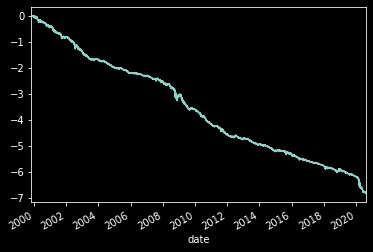

In [11]:
simulator = BollingerBandsSimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period="24H", 
    bollinger_window=10, 
    no_of_std=1.5
)
simulator.simulate()

In [35]:
#Bollinger Band Optimal Calculation
def Bollinger_Band_Optimal(stock_data_df):
    windows = np.linspace(10, 100, 5, dtype=int)
    stds = np.linspace(1, 3, 5)
    periods = np.array([12, 48])

    result_df = pd.DataFrame({
        'period': [], 
        'bollinger_window': [],
        'no_of_std': [],
        'result': []
    })
    for window in windows:
        for std in stds:
            for period in periods:
                simulator = BollingerBandsSimulator(
                    stock_data_df, 
                    #from_date 
                    period="{}H".format(period), 
                    bollinger_window=window, 
                    no_of_std=std,
                    figsize=(14, 7)
                )
                period, bollinger_window, no_of_std, result, signal = simulator.simulate()
                result_df = result_df.append({
                    'period': period, 
                    'bollinger_window': bollinger_window, 
                    'no_of_std': no_of_std, 
                    'result': result,
                    'signal':signal
                }, ignore_index=True)
    bollinger_result=result_df.sort_values(by=['result'], ascending=False)[:5]
    return bollinger_result

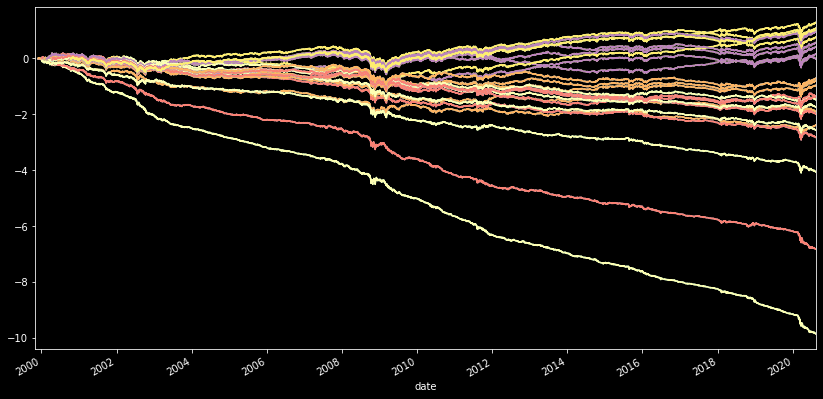

In [36]:
bollinger_result=Bollinger_Band_Optimal(stock_data_df)

In [37]:
opt_bollinger_df=bollinger_result.head()
opt_bollinger_df

period  bollinger_window  no_of_std    result  \
38    12H              77.0        3.0  1.289749   
39    48H              77.0        3.0  1.289749   
49    48H             100.0        3.0  1.081279   
48    12H             100.0        3.0  1.081279   
19    48H              32.0        3.0  1.002476   

                                               signal  
38  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
39  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
49  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
48  date
1999-11-02    NaN
1999-11-03    NaN
1999-...  
19  date
1999-11-02    NaN
1999-11-03    NaN
1999-...

In [46]:
period=opt_bollinger_df['period'].iloc[0]
bollinger_window=int(opt_bollinger_df['bollinger_window'].iloc[0])
no_of_std=opt_bollinger_df['no_of_std'].iloc[0]

In [47]:
type(bollinger_window)

int

('12H', 77, 3.0, 1.2897486036836245, date
 1999-11-02    NaN
 1999-11-03    NaN
 1999-11-04    NaN
 1999-11-05    NaN
 1999-11-08    NaN
              ... 
 2020-08-12    1.0
 2020-08-13    1.0
 2020-08-14    1.0
 2020-08-17    1.0
 2020-08-18    1.0
 Name: Bollinger Signal, Length: 5232, dtype: float64)

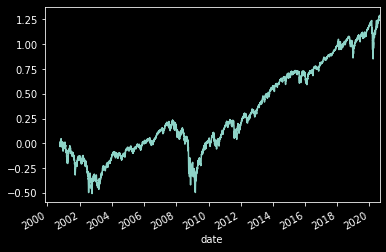

In [48]:
simulator = BollingerBandsSimulator(
    stock_data_df, 
    #from_date="2018-01-01", 
    period=period, 
    bollinger_window=bollinger_window, 
    no_of_std=no_of_std
)
simulator.simulate()

In [53]:
stock_data_df.dropna(subset=['EMA Signal','Bollinger Signal'])

Open      High       Low     Close  Adjusted Close  \
date                                                                 
2000-10-11  137.6250  138.6250  135.1250  136.5312         93.5508   
2000-10-12  137.2812  137.5937  132.7812  133.1250         91.2168   
2000-10-13  132.9375  137.6562  132.8750  137.5625         94.2574   
2000-10-16  137.4062  138.2343  136.6875  138.1875         94.6857   
2000-10-17  138.4375  138.5625  134.4062  134.7500         92.3303   
...              ...       ...       ...       ...             ...   
2020-08-12  335.4400  338.2800  332.8377  337.4400        337.4400   
2020-08-13  336.6100  338.2514  335.8300  336.8300        336.8300   
2020-08-14  336.4100  337.4200  335.6200  336.8400        336.8400   
2020-08-17  337.9400  338.3400  336.8517  337.9100        337.9100   
2020-08-18  338.3400  339.1000  336.6100  338.6400        338.6400   

                Volume  Dividend Amount  Split Coefficient  Daily Returns  \
date                                                                        
2000-10-11  10346000.0              0.0                1.0      -0.008398   
2000-10-12  12336900.0              0.0                1.0      -0.024949   
2000-10-13  11778800.0              0.0                1.0       0.033334   
2000-10-16   5659000.0              0.0                1.0       0.004544   
2000-10-17   7831700.0              0.0                1.0      -0.024876   
...                ...              ...                ...            ...   
2020-08-12  53826128.0              0.0                1.0       0.013942   
2020-08-13  41816146.0              0.0                1.0      -0.001808   
2020-08-14  47260390.0              0.0                1.0       0.000030   
2020-08-17  34496002.0              0.0                1.0       0.003177   
2020-08-18  38193346.0              0.0                1.0       0.002160   

             EWM Short  ...  EMA Signal  EMA Daily Return  \
date                    ...                                 
2000-10-11  140.965377  ...        -1.0         -0.008398   
2000-10-12  139.539854  ...        -1.0         -0.024948   
2000-10-13  139.180335  ...        -1.0          0.033333   
2000-10-16  138.999820  ...        -1.0          0.004543   
2000-10-17  138.227125  ...        -1.0         -0.024876   
...                ...  ...         ...               ...   
2020-08-12  331.998997  ...         1.0          0.013942   
2020-08-13  332.877361  ...         1.0         -0.001808   
2020-08-14  333.597841  ...         1.0          0.000030   
2020-08-17  334.381870  ...         1.0          0.003177   
2020-08-18  335.156076  ...         1.0          0.002160   

            EMA Strategy Return  Bollinger middle  Bollinger STD  \
date                                                               
2000-10-11             0.008398        146.948639       3.402225   
2000-10-12             0.024948        146.802535       3.739082   
2000-10-13            -0.033333        146.689914       3.884203   
2000-10-16            -0.004543        146.599412       3.999873   
2000-10-17             0.024876        146.458990       4.220467   
...                         ...               ...            ...   
2020-08-12             0.013942        309.109481      15.404182   
2020-08-13            -0.001808        309.808961      15.424447   
2020-08-14             0.000030        310.455584      15.501249   
2020-08-17             0.003177        311.133247      15.546607   
2020-08-18             0.002160        311.723247      15.718555   

            Bollinger Upper  Bollinger Lower  Bollinger Signal  \
date                                                             
2000-10-11       157.155313       136.741965               1.0   
2000-10-12       158.019781       135.585289               1.0   
2000-10-13       158.342524       135.037305               1.0   
2000-10-16       158.599030       134.599793               1.0   
2000-10-17       159.120390 

In [18]:
# function to get the EMA of the returns
# return EMA signal values dataframe
def get_EMA(stock_data_df,ticker,short_window,long_window): #typical short is 50 and long is 100
    # Grab just the `date` and `close` from the dataset
    ema_signals = stock_data_df.loc[:, ['Close']].copy()

    # Generate the short and long exponential moving averages (50 and 100 days, respectively)
    ema_signals["EWM Short"] = ema_signals['Close'].ewm(span=short_window).mean()
    ema_signals["EWM Long"] = ema_signals['Close'].ewm(span=long_window).mean()
    ema_signals["Signal"] = 0.0

    # Generate the trading signal 0 or 1,
    # where 0 is when the EWM50 is under the EWM100, and
    # where 1 is when the EWM50 is higher (or crosses over) the SMA100
    ema_signals["Signal"] = np.where(
    ema_signals["EWM Short"][short_window:] > ema_signals["EWM Long"][short_window:], 1.0, 0.0)
    # Calculate the points in time at which a position should be taken, 1 or -1
    ema_signals["Entry/Exit"] = ema_signals["Signal"].diff()
    return ema_signals

In [19]:
ema_signals=get_EMA(stock_data_df,'SPY',short_window,long_window)

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.datetimes.DatetimeIndex'> with these indexers [10.0] of <class 'numpy.float64'>

In [48]:
# function to get the Bolinger Bands of the returns
# return Bolinger Band signal values dataframe
def get_Bollinger(stock_data_df,ticker,bollinger_window,no_of_std):
    # Grab just the `date` and `close` from the dataset
    bollinger_signals = stock_data_df.loc[:, ['Close']].copy()
    bollinger_window=int(bollinger_window)
    no_of_std=int(no_of_std)

    # Calculate rolling mean and standard deviation
    bollinger_signals['Bollinger middle'] = bollinger_signals['Close'].rolling(bollinger_window).mean()
    bollinger_signals['Bollinger STD'] = bollinger_signals['Close'].rolling(bollinger_window).std()

    # Calculate upper and lowers bands of bollinger band
    bollinger_signals['Bollinger Upper']  = bollinger_signals['Bollinger middle'] + (bollinger_signals['Bollinger STD'] * no_of_std)
    bollinger_signals['Bollinger Lower']  = bollinger_signals['Bollinger middle'] - (bollinger_signals['Bollinger STD'] * no_of_std)


    #Calculate the Signal Value for Bollinger
    bollinger_signals['Entry/Exit'] = None

    mode = 'Open'
    for index in range(len(bollinger_signals)):
        if index == 0:
                    continue

        row = bollinger_signals.iloc[index]
        prev_row = bollinger_signals.iloc[index - 1]

                # open?
        if mode == 'Open' and row['Close'] < row['Bollinger Lower'] and prev_row['Close'] > prev_row['Bollinger Lower']:
            bollinger_signals.iloc[index, bollinger_signals.columns.get_loc('Entry/Exit')] = 1
            mode = 'Close'

                # close?
        if mode == 'Close' and row['Close'] > row['Bollinger Upper'] and prev_row['Close'] < prev_row['Bollinger Upper']:
            bollinger_signals.iloc[index, bollinger_signals.columns.get_loc('Entry/Exit')] = -1
            mode = 'Open'
    bollinger_signals.dropna(subset=['Entry/Exit'])
    
    return bollinger_signals

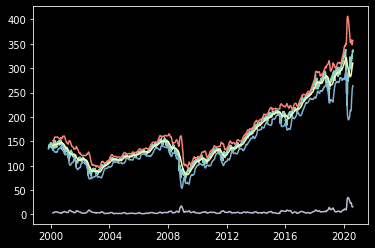

In [49]:
bollinger_signals=get_Bollinger(stock_data_df,'SPY',bollinger_window,no_of_std)
plt.plot(bollinger_signals)

In [51]:
bollinger_signals.tail()

Close  Bollinger middle  Bollinger STD  Bollinger Upper  \
date                                                                   
2020-08-10  335.57        307.654156      15.521354       354.218219   
2020-08-11  332.80        308.351558      15.427619       354.634416   
2020-08-12  337.44        309.109481      15.404182       355.322026   
2020-08-13  336.83        309.808961      15.424447       356.082301   
2020-08-14  336.84        310.455584      15.501249       356.959330   

            Bollinger Lower Entry/Exit  
date                                    
2020-08-10       261.090093       None  
2020-08-11       262.068701       None  
2020-08-12       262.896936       None  
2020-08-13       263.535621       None  
2020-08-14       263.951839       None

In [ ]:
# function to get the MACD Value of the returns
# return MACD signal values dataframe
def get_MACD(stock_data_df,ticker, span1, span2,span3): ##typically span = 12, 26, 9
    # Grab just the `date` and `close` from the dataset
    macd_signals = stock_data_df.loc[:, ['Close']].copy()

    
    exp1 = macd_signals.Close.ewm(span1, adjust=False).mean()
    exp2 = macd_signals.Close.ewm(span2, adjust=False).mean()
    macd = exp1-exp2
    macd_out = macd.ewm(span3, adjust=False).mean()
    
    macd_signals["Signal"] = np.where(macd > macd_out, 1.0, 0.0)
    macd_signals["MACD Entry/Exit"] = mac_signals["Signal"].diff()

    return macd_signals


In [ ]:
#function to get all trading signals
#return data frame holding trading signals
def get_trading_signals(ema_signal_df,boligner_signals_df,macd_signals_df):
    trading_signals_df=pd.concat([ema_signal_df, bolinger_signal_df,mcad_signal_df],axis=1,    join="inner")
    trading_signals_df['Signal']=trading_signals_df['EMA Signal']+ trading_signals_df['Bolinger Signal']+ trading_signals_df['MACD Signal']
    trading_signals_df['Overall Entry/Exit']=trading_signals_df['Signal'].diff()
    return trading_signals_df

In [ ]:

#Plot Signals and Indicators Against Price
def plot_signals(trading_signals_df, ema_signals, mac_signals)
    # Visualize exit position relative to close price
    exit = trading_signals_df['Overall Entry/Exit'] == -1.0].hvplot.scatter(
        color='red',
        marker='v',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

    # Visualize entry position relative to close price
    entry = trading_signals_df['Overall Entry/Exit'] == 1.0].hvplot.scatter(
        color='green',
        marker='^',
        size=200,
        legend=False,
        ylabel='Price in $',
        width=1000,
        height=400
    )

# Visualize close price for the investment
security_close = trading_signals_df[[f"{ticker}S&P 500 close"]].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize moving averages
moving_avgs = ema_signals[['EWM50', 'EWM100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize bolinger bands
#bolinger_bands = Bolinger_signal_df[['EWM50', 'EWM100']].hvplot(
#    ylabel='Price in $',
#    width=1000,
#    height=400
#)

# Visualize moving averages
#macd = macd_signals[['EWM50', 'EWM100']].hvplot(
#    ylabel='Price in $',
#    width=1000,
#    height=400
#)

# Overlay plots
stock_signals_plot = security_close * moving_avgs * entry * exit
stock_signals_plot.opts(xaxis=None, title =f"Entry/Exit {ticker} Signals")